In [0]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse

from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass

!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

!mkdir -p drive
!google-drive-ocamlfuse drive
!cp -r drive/seismic_images/src .
!cp drive/seismic_images/Lapteva_faults_10k.pickle .

E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 110856 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.1-0ubuntu3~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.1-0ubuntu3~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.1-0ubuntu3~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=ht

In [0]:
!cp -r drive/seismic_images/src .

In [0]:
%env CUDA_VISIBLE_DEVICES=0

Параметры автосохранения и отображения 

In [0]:

%autosave 180
%load_ext autoreload
%autoreload 2
%matplotlib inline

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

Autosaving every 180 seconds


Подгружаем необходимые для работы библиотеки и функции

In [0]:
import sys
import os
import numpy as np
import scipy as sp
import pandas as pd

import pickle
import pylab as plt
import src.utils as ut
from tqdm import tqdm_notebook as tqdm

Using TensorFlow backend.


# Load Data

Подгружаем набор данных, сформированный для обучения (содержит данные о среде, разломах); X_set - набор сейсмических изображений, y_set - набор разломов шириной в 1 пиксель, определенных вручную.
Titles - название, соответствующее изображению, содержит информацию о номере разреза и координаты участка

In [0]:
import portpicker
import threading
import socket
import IPython

from six.moves import socketserver
from six.moves import SimpleHTTPServer

class V6Server(socketserver.TCPServer):
  address_family = socket.AF_INET6

class Handler(SimpleHTTPServer.SimpleHTTPRequestHandler):
  def do_GET(self):
    self.send_response(200)
    # If the response should not be cached in the notebook for
    # offline access:
    # self.send_header('x-colab-notebook-cache-control', 'no-cache')
    self.end_headers()
    self.wfile.write(b'''
      document.querySelector('#output-area').appendChild(document.createTextNode('Script result!'));
    ''')

port = portpicker.pick_unused_port()

def server_entry():
    httpd = V6Server(('::', port), Handler)
    # Handle a single request then exit the thread.
    httpd.serve_forever()

thread = threading.Thread(target=server_entry)
thread.start()

# Display some HTML referencing the resource.
display(IPython.display.HTML('<script src="https://localhost:{port}/"></script>'.format(port=port)))

In [0]:
import portpicker
import threading
import socket
import IPython

from six.moves import socketserver
from six.moves import SimpleHTTPServer

class V6Server(socketserver.TCPServer):
  address_family = socket.AF_INET6

class Handler(SimpleHTTPServer.SimpleHTTPRequestHandler):
  def do_GET(self):
    self.send_response(200)
    # If the response should not be cached in the notebook for
    # offline access:
    # self.send_header('x-colab-notebook-cache-control', 'no-cache')
    self.end_headers()
    self.wfile.write(b'''
      document.querySelector('#output-area').appendChild(document.createTextNode('Script result!'));
    ''')

port = portpicker.pick_unused_port()

def server_entry():
    httpd = V6Server(('::', port), Handler)
    # Handle a single request then exit the thread.
    httpd.serve_forever()

thread = threading.Thread(target=server_entry)
thread.start()

# Display some HTML referencing the resource.
display(IPython.display.HTML('<script src="https://localhost:{port}/"></script>'.format(port=port)))

In [0]:
with open('Lapteva_faults_10k.pickle', 'rb') as handle:
    data_set = pickle.load(handle)  

X_set = data_set['X_set'] 
y_set = data_set['y_set'] 
Titles = data_set['fault_title'] 

Создаем набор разломов шириной в 2 пикселя. 

Делим выборки на тестовые и валидационные, задаем соотношение распределения через test_size, 
random_state- число, используемое генератором случайных чисел.

Присваиваем каждой выборке принадлежность к классам 0-среда, 1-разлом

In [0]:
from keras.utils import to_categorical #отвечает за присвоение набору данных значения класса
from sklearn.model_selection import train_test_split #функция, отвечающая за разделение набора данных на тестовую и валидационную выборки

In [0]:
y_set_wide = y_set.copy()
y_set_wide += np.roll(y_set_wide, -1, axis=2)
y_set_wide[y_set_wide > 1] = 1 

X_train, X_test, y_train, y_test, y_set_wide_train, y_set_wide_test = train_test_split(
    X_set, y_set, y_set_wide, test_size=.20, random_state=35
)


y_train = to_categorical(y_train, num_classes=2) 
y_test = to_categorical(y_test, num_classes=2)

y_set_wide_train = to_categorical(y_set_wide_train, num_classes=2)
y_set_wide_test = to_categorical(y_set_wide_test, num_classes=2)

# y_set = to_categorical(y_set, num_classes=2)
print('Train shape', X_train.shape)
print('X_test shape', X_test.shape)

Train shape (8192, 64, 64)
X_test shape (2048, 64, 64)


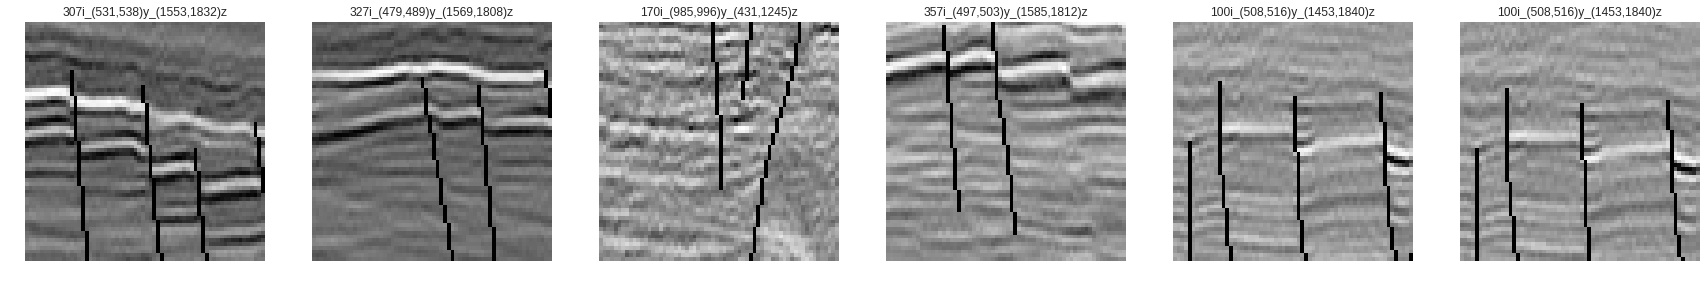

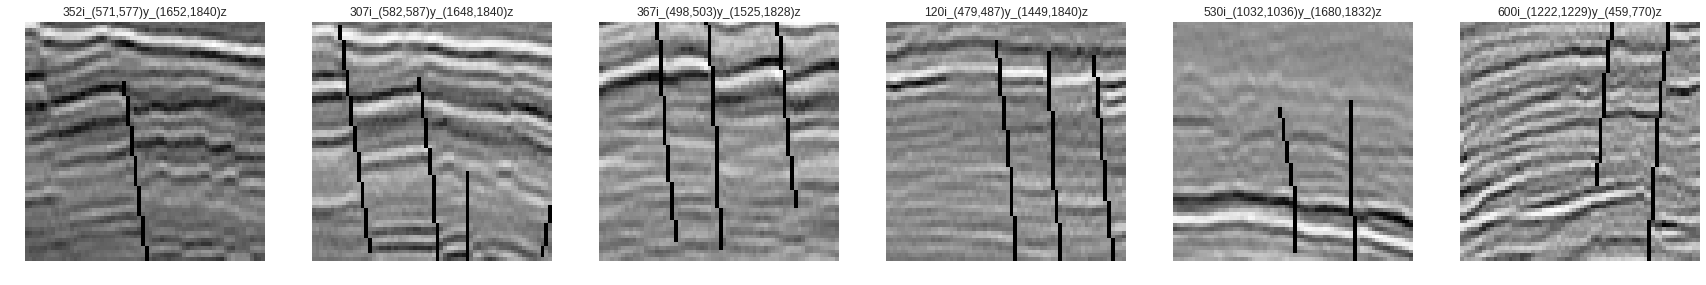

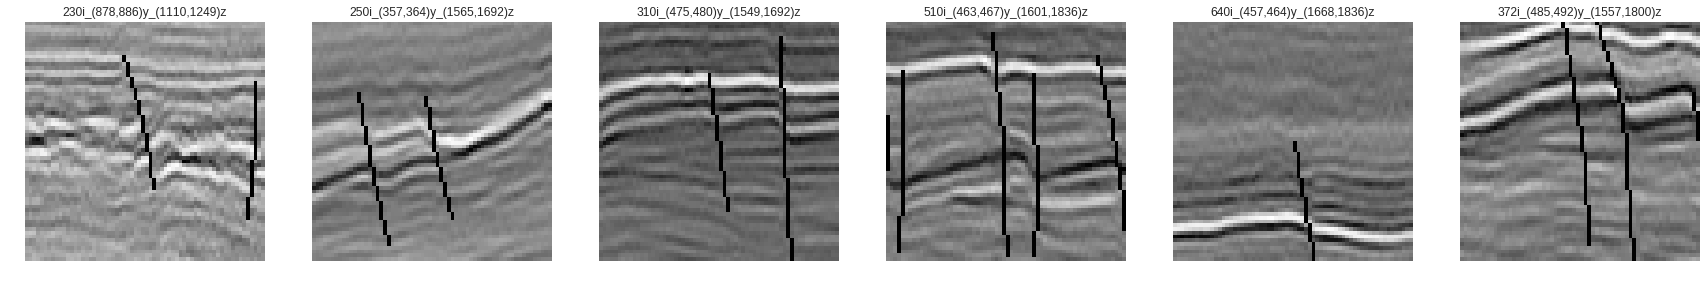

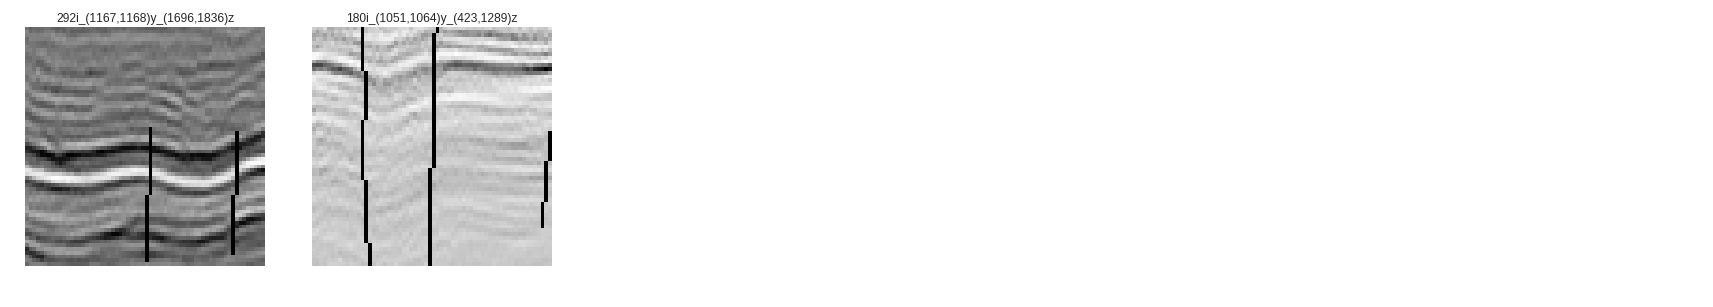

In [0]:
ut.show_image_dashboard(X_set[:20], y_set[:20], titles=Titles, fig_hight=5, threshold=.5, alpha=None, n_cols=6,image_cmap = 'Greys')

In [0]:
pltclb = ut.PlotLosses() #отрисовка функции потерь

# Load_metricks

Загружаем метрику для оценки точности результата работы нейросети (вычисляет точность определения классов)

In [0]:
from sklearn.metrics import accuracy_score, roc_curve, auc, f1_score, confusion_matrix, classification_report, jaccard_similarity_score
import itertools

#Оценочная кривая показывает насколько хорошо результат работв нейросети совпадает с входными данными
def evaluate_roc(y_set, y_score):

    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(2):
        fpr[i], tpr[i], _ = roc_curve(y_set[..., i].ravel(), y_score[..., i].ravel())
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_set.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    plt.figure()
    lw = 2
    colors = {
        0: 'aqua', 
        1: 'darkorange', 
        'micro': 'cornflowerblue',
    }
    for c in list(fpr.keys()):
        plt.plot(fpr[c], tpr[c], color=colors[c],
                 lw=lw, label='class {} (area = {:.2f})'.format(c, roc_auc[c]))

    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

Строим резрешающую матрицу: определяет число истинных и ложных откликов работы алгоритма: tp,tn,fp,fn - положительные, истинно отрицательные, ложноположительные, ложноотрицательные

In [0]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    


## Model(autoencode)

Модель автоэнкодера (кодирует и декодирует изображение)

In [0]:

import keras
from keras.losses import binary_crossentropy, sparse_categorical_crossentropy
from  itertools import product


def weighted_categorical_crossentropy2(weights):
    def loss(y_true, y_pred):
        nb_cl = len(weights)
        final_mask = keras.backend.zeros_like(y_pred[:, 0])
        y_pred_max = keras.backend.max(y_pred, axis=1, keepdims=True)
        y_pred_max_mat = keras.backend.equal(y_pred, y_pred_max)
        for c_p, c_t in product(range(nb_cl), range(nb_cl)):
            final_mask += (weights[c_t, c_p] * y_pred_max_mat[:, c_p] * y_true[:, c_t])
        return keras.backend.categorical_crossentropy(y_pred, y_true) * final_mask

    return loss


def weighted_binary_crossentropy(zero_weight):
    # def f(y_true, y_pred):
    #     return mean(binary_crossentropy(y_true, y_pred), axis=-1)
    # return f
    one_weight = 1 - zero_weight

    def loss(y_true, y_pred):
        # Original binary crossentropy (see losses.py):
        # K.mean(K.binary_crossentropy(y_true, y_pred), axis=-1)

        # Calculate the binary crossentropy
        b_ce = binary_crossentropy(y_true, y_pred)

        # Apply the weights
        weight_tensor = y_true[..., 0] * one_weight + (1. - y_true[..., 0]) * zero_weight
        weighted_b_ce = weight_tensor * b_ce

        # Return the mean error
        return keras.backend.mean(weighted_b_ce)

    return loss


def weighted_categorical_crossentropy(weights):
    """
    A weighted version of keras.objectives.categorical_crossentropy

    Variables:
        weights: numpy array of shape (C,) where C is the number of classes

    Usage:
        weights = np.array([0.5,2,10]) # Class one at 0.5, class 2 twice the normal weights, class 3 10x.
        loss = weighted_categorical_crossentropy(weights)
        model.compile(loss=loss,optimizer='adam')
    """

    weights = keras.backend.variable(weights)

    def loss(y_true, y_pred):
        # scale predictions so that the class probas of each sample sum to 1
        y_pred /= keras.backend.sum(y_pred, axis=-1, keepdims=True)
        # clip to prevent NaN's and Inf's
        y_pred = keras.backend.clip(y_pred, keras.backend.epsilon(), 1 - keras.backend.epsilon())
        # calc
        loss = y_true * keras.backend.log(y_pred) * weights
        loss = -keras.backend.sum(loss, -1)
        return loss

    return loss


In [0]:
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D, GlobalAveragePooling2D, GlobalMaxPooling2D, AveragePooling2D
from keras.layers import Input, Dense,Concatenate, Flatten, Reshape, Permute, BatchNormalization, Dropout, Activation
from keras.optimizers import RMSprop
from keras.models import model_from_json, Model
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.advanced_activations import PReLU
from keras.layers.advanced_activations import ELU
from keras.layers import Lambda
from keras.losses import binary_crossentropy, sparse_categorical_crossentropy
from keras.layers.merge import concatenate
import numpy as np
#from .losses import *
import keras

def create_conv2d_ae():
    dropout=0.3
    x, input_img = [Input(shape=(None, None, 1))]*2

    x = Conv2D(32, (7, 7), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Dropout(dropout*0.5)(x)
    x = Conv2D(16, (5, 5), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Dropout(dropout)(x)
    encoded = Conv2D(1, (3, 3), activation=None, padding='same')(x)

    x, input_encoded = [Input(shape=(8, 8, 1))]*2
    x = Conv2D(32, (7, 7), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Dropout(dropout)(x)
    x = Conv2D(16, (5, 5), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Dropout(dropout)(x)
    decoded = Conv2D(2, (3, 3), activation='softmax', padding='same')(x)

    # Модели
    encoder = Model(input_img, encoded, name="encoder")
    decoder = Model(input_encoded, decoded, name="decoder")
    autoencoder = Model(input_img, decoder(encoder(input_img)), name="autoencoder")
    
    optimizer = keras.optimizers.Adam(
        lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False
    )
    
    loss = weighted_categorical_crossentropy(np.array([.1, 1]))
#     loss='categorical_crossentropy'
    autoencoder.compile(optimizer=optimizer,
                  loss=loss, metrics=['accuracy'])
    return autoencoder
def create_conv2d_ae_2_decoder():
    dropout=0.3
    x, input_img = [Input(shape=(None, None, 1))]*2

    x = Conv2D(32, (7, 7), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Dropout(dropout*0.5)(x)
    x = Conv2D(16, (5, 5), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Dropout(dropout)(x)
    encoded = Conv2D(1, (3, 3), activation=None, padding='same')(x)

    x, input_encoded = [Input(shape=(8, 8, 1))]*2
    x = Conv2D(32, (7, 7), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Dropout(dropout)(x)
    x = Conv2D(16, (5, 5), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Dropout(dropout)(x)
    decoded = Conv2D(2, (3, 3), activation='softmax', padding='same')(x)

    # Модели
    encoder = Model(input_img, encoded, name="encoder")
    decoder = Model(input_encoded, decoded, name="decoder")
    autoencoder = Model(input_img, decoder(encoder(input_img)), name="autoencoder")
    
    optimizer = keras.optimizers.Adam(
        lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False
    )
    
    loss = weighted_categorical_crossentropy(np.array([.1, 1]))
#     loss='categorical_crossentropy'
    autoencoder.compile(optimizer=optimizer,
                  loss=loss, metrics=['accuracy'])
    return autoencoder


In [0]:

model_1 = create_conv2d_ae() 
model_1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 1)     0         
_________________________________________________________________
encoder (Model)              (None, None, None, 1)     14561     
_________________________________________________________________
decoder (Model)              multiple                  14706     
Total params: 29,267
Trainable params: 29,267
Non-trainable params: 0
_________________________________________________________________


Обучение

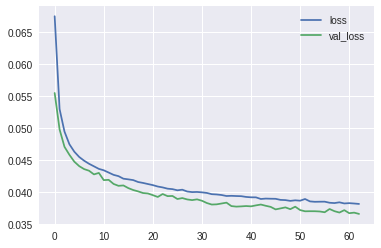

Epoch 64/64
7372/7372 [==============================] - 6s 760us/step - loss: 0.0380 - acc: 0.9009 - val_loss: 0.0369 - val_acc: 0.9143


In [0]:
model_1.fit(
    X_train[..., None],
    y_train,
    epochs=64,
    batch_size=64,
    shuffle=True,
    callbacks=[pltclb],
    validation_split=.1, 
    verbose=True
)

Результат работы автоэнкодера

In [0]:
ut.save_keras_model(model_1, 'model_ae_1_decoder')

In [0]:
pred_1 = model_1.predict(X_test[..., None])

In [0]:
ut.show_image_dashboard(X_train[:20], y_train[...,1][:20], pred_1[...,1][:20], titles=Titles, fig_hight=5, threshold=.5, alpha=None, n_cols=6)

In [0]:
from sklearn.metrics import precision_recall_curve
from sklearn.utils.fixes import signature

X = pred_2.reshape(pred_2.shape + (1,))
y = y_test.reshape(y_test.shape + (1,))
y_score = X[:, :, :, 1:]
y_label = y[:, :, :, 1:] > 0.5

y_score = y_score.reshape([y_score.size,])
y_label = y_label.reshape([y_label.size,])

precision, recall, _ = precision_recall_curve(y_label, y_score)

step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])

### Model(autoencoder with 2 decoder)

In [0]:
def create_conv2d_ae_2_decoder():
    dropout=0.3
    x, input_img = [Input(shape=(64, 64, 1), name='input_x')]*2

    x = Conv2D(32, (7, 7), activation='relu', padding='same')(x)
    pooling1 = x = MaxPooling2D((2, 2), padding='same')(x)
    dropout1 = x = Dropout(dropout)(x)
    x = Conv2D(16, (5, 5), activation='relu', padding='same')(x)
    pooling2 = x = MaxPooling2D((2, 2), padding='same')(x)
    dropout2 = x = Dropout(dropout)(x)
    encoded = Conv2D(1, (3, 3), activation='relu', padding='same')(x)

    x, input_encoded1 = [Input(shape=(8, 8, 1))]*2
    x = Conv2D(32, (7, 7), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Dropout(dropout)(x)
    x = Conv2D(16, (5, 5), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Dropout(dropout)(x)
    decoded1 = Conv2D(1, (3, 3), activation=None, padding='same', name='seismic')(x)
  
    x, input_encoded2 = [Input(shape=(8, 8, 1))]*2
    x = Conv2D(32, (7, 7), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Dropout(dropout)(x)
    x = Conv2D(16, (5, 5), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    
    x = Dropout(dropout)(x)
    skipped = concatenate([x, dropout1])
    decoded2 = Conv2D(2, (3, 3), activation='softmax', padding='same', name='faults')(x)
    # Модели
    encoder = Model(input_img, encoded, name="encoder")
    decoder1 = Model(input_encoded1, decoded1, name="decoder1")
    decoder2 = Model(input_encoded2, decoded2, name="decoder2")
    
    autoencoder = Model(input_img, [decoder1(encoder(input_img)), decoder2(encoder(input_img))], name="autoencoder")
    
    optimizer = keras.optimizers.Adam(
        lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False
    )
    
    loss = weighted_categorical_crossentropy(np.array([.1, 1]))

    autoencoder.compile(
        optimizer=optimizer,
        loss={
            'decoder1': 'mse',
            'decoder2': loss
        }, 
        loss_weights={
            'decoder1': 1,
            'decoder2': 1
        },
        metrics=['accuracy']
    )
    return autoencoder

In [63]:

model_2 = create_conv2d_ae_2_decoder() 
model_2.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_x (InputLayer)            (None, 64, 64, 1)    0                                            
__________________________________________________________________________________________________
encoder (Model)                 (None, 16, 16, 1)    14561       input_x[0][0]                    
                                                                 input_x[0][0]                    
__________________________________________________________________________________________________
decoder1 (Model)                multiple             14561       encoder[1][0]                    
__________________________________________________________________________________________________
decoder2 (Model)                multiple             14706       encoder[2][0]                    
Total para

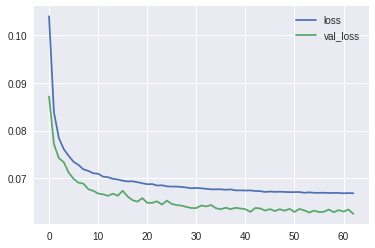

Epoch 64/64
7372/7372 [==============================] - 8s 1ms/step - loss: 0.0667 - decoder1_loss: 0.0244 - decoder2_loss: 0.0423 - decoder1_acc: 3.6618e-04 - decoder2_acc: 0.9018 - val_loss: 0.0629 - val_decoder1_loss: 0.0219 - val_decoder2_loss: 0.0410 - val_decoder1_acc: 3.0071e-04 - val_decoder2_acc: 0.9062


In [64]:
model_2.fit(
    X_train[..., None],
     {'decoder1': X_train[..., None], 'decoder2': y_train},
    epochs=64,
    batch_size=64,
    shuffle=True,
    callbacks=[pltclb],
    validation_split=.1, 
    verbose=True
)

In [0]:
ut.save_keras_model(model_2, 'model_ae_2_decoder')

In [0]:
pred_2 = model_2.predict(X_test[..., None])

(0.0, 1.0)

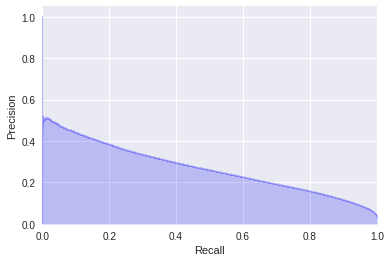

In [68]:
from sklearn.metrics import precision_recall_curve
from sklearn.utils.fixes import signature

X = pred_2[1].reshape(pred_2[1].shape + (1,))
y = y_test.reshape(y_test.shape + (1,))
y_score = X[:, :, :, 1:]
y_label = y[:, :, :, 1:] > 0.5

y_score = y_score.reshape([y_score.size,])
y_label = y_label.reshape([y_label.size,])

precision, recall, _ = precision_recall_curve(y_label, y_score)

step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])

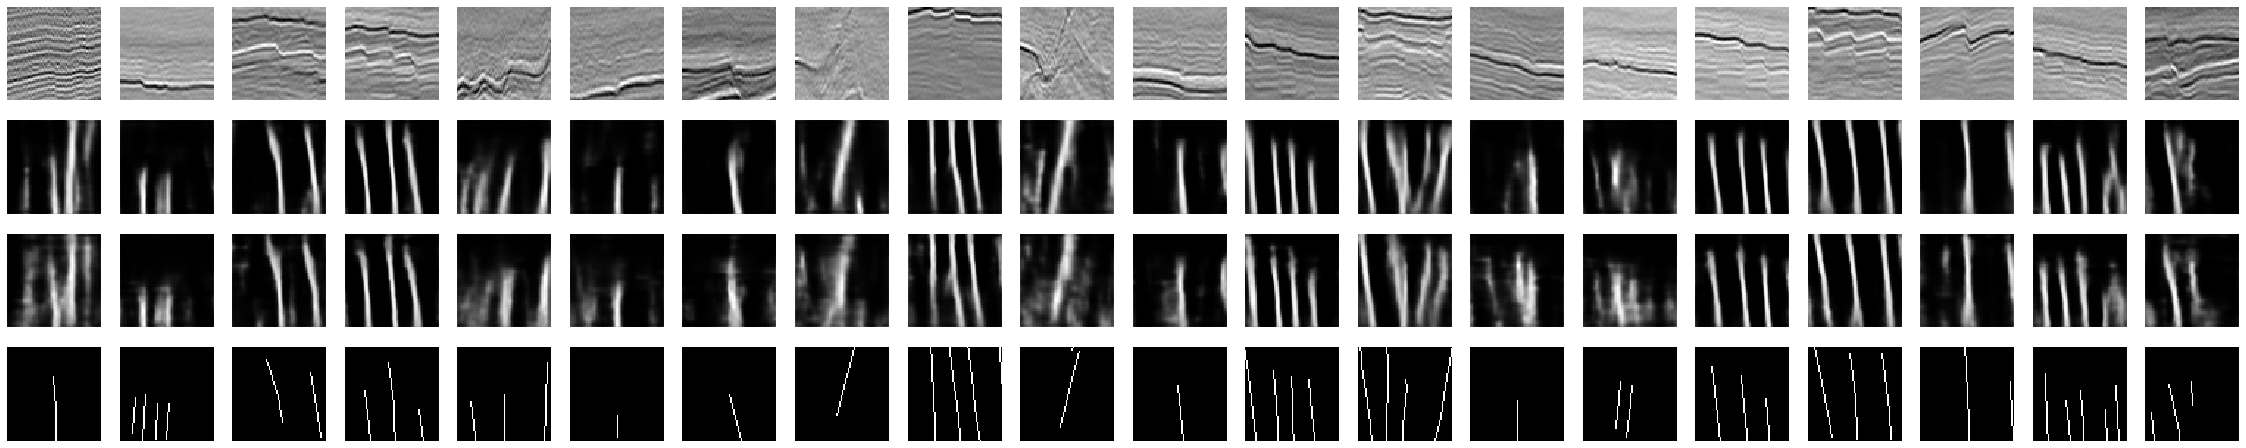

In [137]:
%matplotlib inline
def plot_digits(*args):
    args = [x.squeeze() for x in args]
    n = min([x.shape[0] for x in args])
    
    plt.figure(figsize=(2 * n, 2 * len(args)))
    for j in range(n):
        for i, _ in enumerate(args):
        # for i in range(len(args)):
            ax = plt.subplot(len(args), n, i * n + j + 1)
            plt.imshow(args[i][j])
            plt.gray()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
    plt.show()

n = 20
trash = 0.2

answers = y_test[:n]
imgs = X_test[..., None]
decoded_imgs_2 = model_2.predict(imgs[:n],batch_size=n)[1]
decoded_imgs_bool_2 = decoded_imgs > trash

model_1 = ut.load_keras_model('model_ae_1_decoder')
decoded_imgs_1 = model_1.predict(imgs[:n],batch_size=n)
decoded_imgs_bool_1 = decoded_imgs > trash
#plot_digits(X_test[:n],decoded_imgs_1[...,1], decoded_imgs_bool_1[...,1], decoded_imgs_2[...,1], decoded_imgs_bool_2[...,1], answers[...,1])
plot_digits(X_test[:n],decoded_imgs_1[...,1],decoded_imgs_2[...,1], answers[...,1])
 

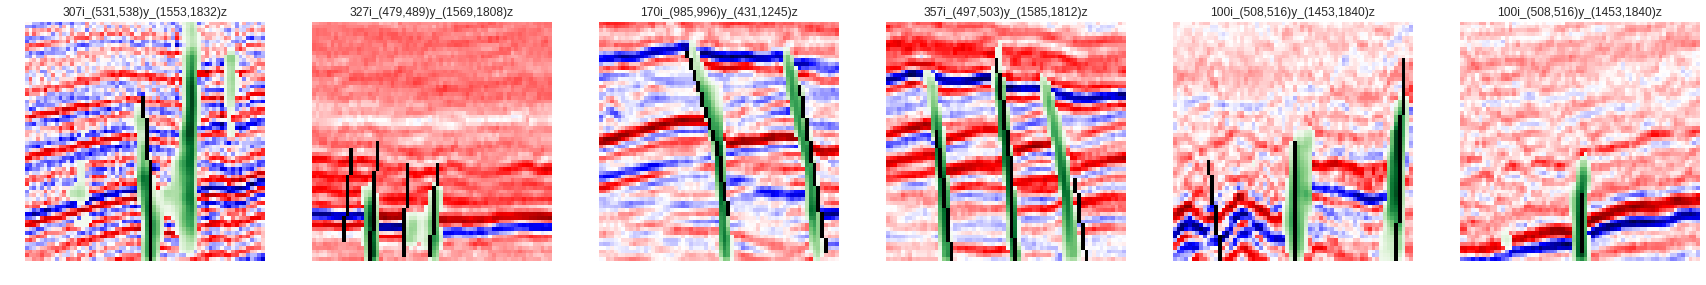

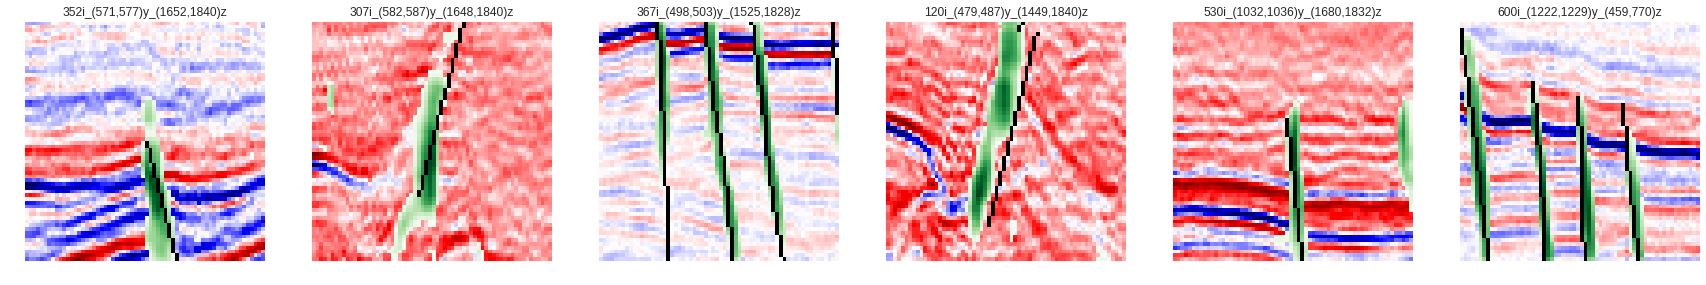

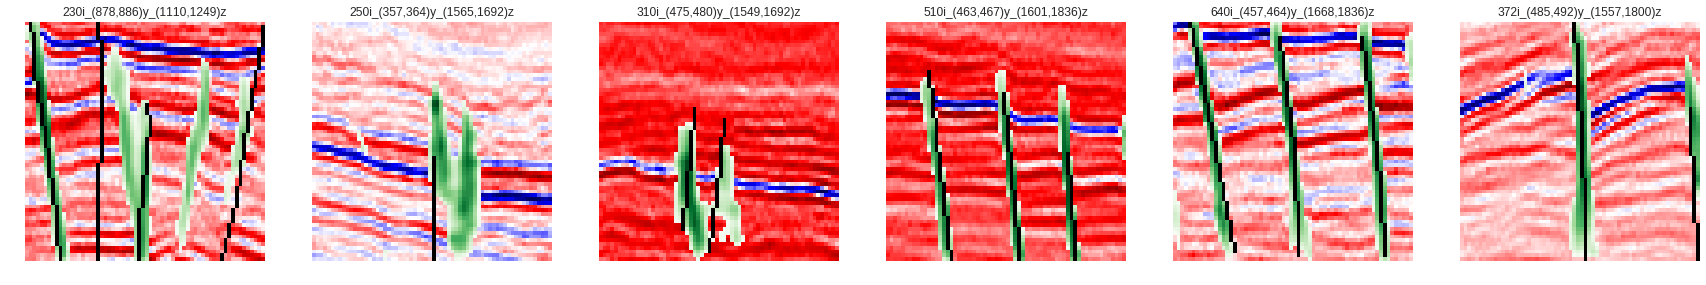

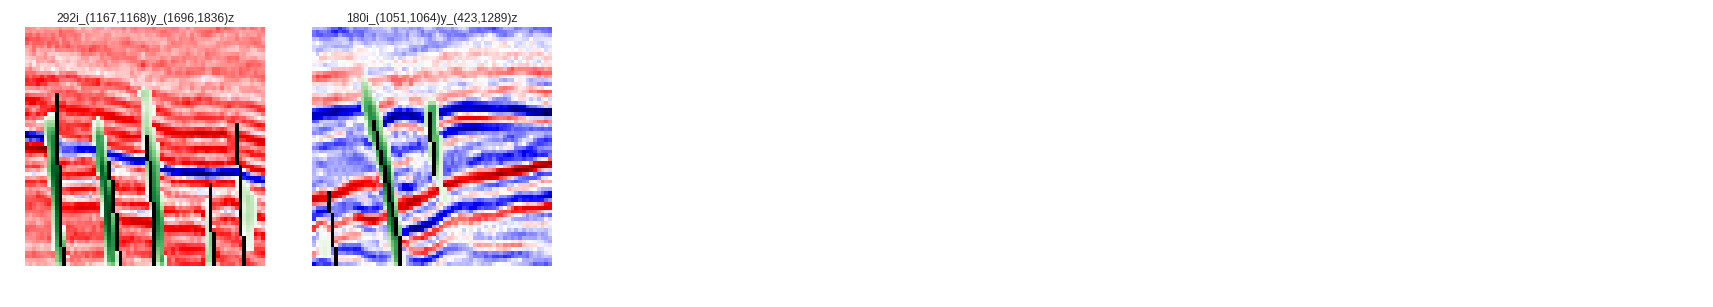

In [129]:
ut.show_image_dashboard(X_test[:20], y_test[...,1][:20], pred_2[1][...,1][:20], titles=Titles, fig_hight=5, threshold=.5, alpha=None, n_cols=6)

In [0]:
ut.show_image_dashboard(X_test[:20], y_test[...,1][:20], pred_2[1][...,1][:20], titles=Titles, fig_hight=5, threshold=.5, alpha=None, n_cols=6)